# Carte de corrélation Bigfoot

## Import des bibiliothèques

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl

from datetime import datetime

## Préparation du jeu de données

In [2]:
# importer données du fichier csv
bigfoot = pd.read_csv("./data/bigfoot.csv", sep = ",")

In [3]:
bigfoot = bigfoot[bigfoot.classification != "Class C"]

In [4]:
# ajoute des colonnes jour, mois, année
year = bigfoot['date'].copy()
month = bigfoot['date'].copy()
day = bigfoot['date'].copy()

for i in bigfoot['date'].index:
    d = bigfoot['date'][i]
    if str(d) != "nan":
        d_datetime = datetime.strptime(str(d),'%Y-%m-%d')
        year[i] = d_datetime.year
        month[i] = d_datetime.month
        day[i] = d_datetime.day

bigfoot = bigfoot.assign(year = year)
bigfoot = bigfoot.assign(month = month)
bigfoot = bigfoot.assign(day = day)

# temperature_high : fahrenheit en celsius
# temperature_mid : fahrenheit en celsius
# temperature_low : fahrenheit en celsius
# dew_point : fahrenheit en celsius
# wind_speed : miles par heure en kilomètre par heure
# precip_intensity : inch en cm
# visibility : miles en kilomètre
# latitude / longitude : coordonnées polaires
bigfoot = bigfoot.assign(
    temperature_high = (bigfoot.temperature_high - 32) * 5 / 9,
    temperature_mid = (bigfoot.temperature_mid - 32) * 5 / 9,
    temperature_low = (bigfoot.temperature_low - 32) * 5 / 9,
    dew_point = (bigfoot.dew_point - 32) * 5 / 9,
    wind_speed = bigfoot.wind_speed * 1.609344,
    precip_intensity = bigfoot.precip_intensity * 2.54,
    visibility = bigfoot.visibility * 1.609344,
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)

# pour le "titre" garde la partie [titre] du format inital “Report [numéro] : [titre]”
bigfoot = bigfoot.assign(
    title = bigfoot.title.str.replace(r'^Report \d*: ', '')
)

# transformation de precip_type en deux colonnes snow et rain
# transformation de season en quatre colonnes
bigfoot["rain"] = 0.0
bigfoot.loc[bigfoot.precip_type == "rain", "rain"] = 1.0
bigfoot["snow"] = 0.0
bigfoot.loc[bigfoot.precip_type == "snow", "snow"] = 1.0

bigfoot["summer"] = 0.0
bigfoot.loc[bigfoot.season == "Summer", "summer"] = 1.0
bigfoot["spring"] = 0.0
bigfoot.loc[bigfoot.season == "Spring", "spring"] = 1.0
bigfoot["fall"] = 0.0
bigfoot.loc[bigfoot.season == "Fall", "fall"] = 1.0
bigfoot["winter"] = 0.0
bigfoot.loc[bigfoot.season == "Winter", "winter"] = 1.0

bigfoot.drop(columns="geohash", inplace=True)
bigfoot.drop(columns="date", inplace=True)
bigfoot.drop(columns=["precip_type"], inplace=True)

C:\Users\Aurelie\AppData\Local\Temp\ipykernel_9328\847808280.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
  title = bigfoot.title.str.replace(r'^Report \d*: ', '')


### Typage des variables

In [5]:
# dictionnaire des états des Etats-Unis et leur abbrévation
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

# variables catégorielles
# Attention! Conséquence, variables catégorielles ont des valeurs <NA> à la place de NaN.
bigfoot.county = pd.Categorical(bigfoot.county)
bigfoot.state = pd.Categorical(bigfoot.state, categories=us_state_to_abbrev.keys())
bigfoot.classification = bigfoot.classification.replace("Class A", "A")
bigfoot.classification = bigfoot.classification.replace("Class B", "B")
bigfoot.classification = pd.Categorical(bigfoot.classification, categories=["A", "B"], ordered=True)

bigfoot.observed = bigfoot.observed.astype('str')
bigfoot.location_details = bigfoot.location_details.astype('str')
bigfoot.title = bigfoot.title.astype('str')
bigfoot.summary = bigfoot.summary.astype('str')
bigfoot.number = bigfoot.number.astype('Int64')
bigfoot.day = bigfoot.day.astype(float)
bigfoot.month = bigfoot.month.astype(float)
bigfoot.year = bigfoot.year.astype(float)

# Dealing with missing values
bigfoot[["latitude", "longitude"]] = bigfoot[["latitude", "longitude"]].fillna(bigfoot.groupby('state')[["latitude", "longitude"]].transform('mean'))
bigfoot = bigfoot.assign(
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)
bigfoot[["day", "month", "year"]] = bigfoot[["day", "month", "year"]].fillna(bigfoot.groupby('season')[["day", "month", "year"]].transform('median'))

### Observer les corrélations pour supprimer des variables

In [6]:
bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point"], inplace=True)

# pour la carte des corrélations
# one-hot encoding de la classification avec 1 pour A et 0 pour B
bigfoot["class_A_B"] = 0.0
bigfoot.loc[bigfoot.classification == "A", "class_A_B"] = 1.0

features = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
    'r',
    'theta',
    'latitude',
    'longitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day',
    'class_A_B' # pour la carte des corrélations
    ]


In [7]:
cat_cols = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
    'class_A_B'
]

numeric_cols = [
    'r',
    'theta',
    'longitude',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
]

In [8]:
def fill_missing(df):
    '''
    replace empty values by column's mean in dataframe
    '''
    return df.copy().fillna(df.mean())

def calculate_zscore(df):
    '''
    scales columns in dataframe using z-score
    '''
    df = df.copy()
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

    return df

def normalize_column_modality(df):
    '''
    divides each column by the probability μₘ of the modality 
    (number of ones in the column divided by N) only for one hot columns
    '''
    df = df.copy()
    length = len(df)
    for col in df.columns:
        weight = math.sqrt(sum(df[col])/length)
        df[col] = df[col]/weight

    return df

def center_columns(df):
    '''
    center columns by subtracting the mean value
    '''
    df = df.copy()
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())
    return df

In [9]:
bigfoot_num = pd.DataFrame(calculate_zscore(fill_missing(bigfoot[numeric_cols])))
bigfoot_cat = center_columns(normalize_column_modality(bigfoot[cat_cols]))
bigfoot_fill = pd.concat([bigfoot_num, bigfoot_cat], axis=1)

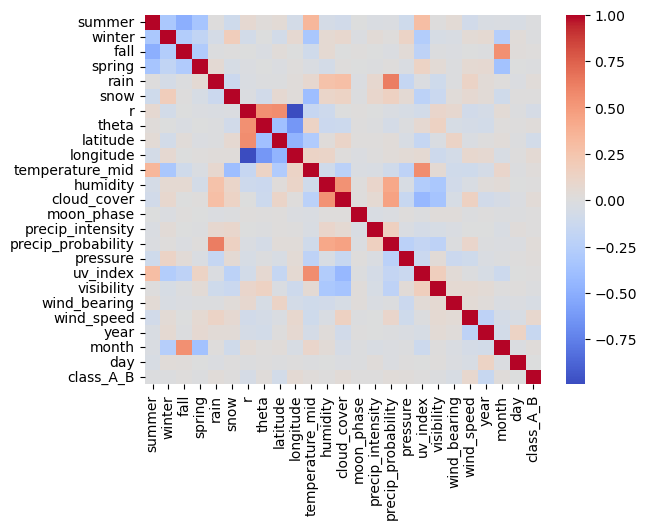

In [10]:
corr = bigfoot_fill[features].corr()
sns.heatmap(corr, cmap="coolwarm")
plt.show()

In [11]:
abs(corr["class_A_B"]).sort_values(ascending=False)

class_A_B             1.000000
year                  0.148092
wind_speed            0.086845
latitude              0.078682
r                     0.058363
longitude             0.050904
wind_bearing          0.043205
cloud_cover           0.034737
rain                  0.033324
precip_probability    0.030528
pressure              0.024270
theta                 0.022350
temperature_mid       0.019390
month                 0.019271
fall                  0.012547
spring                0.010401
snow                  0.008999
moon_phase            0.008743
humidity              0.006955
winter                0.006026
visibility            0.005693
uv_index              0.005635
summer                0.005061
precip_intensity      0.003806
day                   0.003646
Name: class_A_B, dtype: float64

In [12]:
corr["class_A_B"][corr[abs(corr["class_A_B"])> 0.02].index].sort_values(ascending=False)

class_A_B             1.000000
wind_speed            0.086845
longitude             0.050904
cloud_cover           0.034737
rain                  0.033324
precip_probability    0.030528
pressure              0.024270
theta                 0.022350
wind_bearing         -0.043205
r                    -0.058363
latitude             -0.078682
year                 -0.148092
Name: class_A_B, dtype: float64